## Tugas Mandiri 1 - Eksplorasi DL Model Training
### Reynaldi Cristian Simamora
### 122140116
### Deep Learning RB


#### Eksplorasi Artificial Neural Network (ANN) pada kasus klasifikasi biner (2 kelas).

---
Import Library
1. matplotlib.pyplot as plt → untuk membuat grafik/visualisasi data dan hasil klasifikasi.
2. numpy as np → untuk operasi matematis dan manipulasi array.
3. torch → library PyTorch, dipakai untuk membuat model ANN, melakukan training, dan komputasi tensor.
4. torch.utils.data.DataLoader, TensorDataset → untuk mengatur data dalam bentuk batch saat training.
5. sklearn.datasets.make_circles, make_classification → untuk membuat dataset buatan (sintetis) yang dipakai melatih model.
6. torchmetrics.classification.BinaryAccuracy → metrik untuk menghitung akurasi pada klasifikasi biner (apakah prediksi model benar atau salah).

---

In [1]:
# -------------------------------------------------
# Modul 01 - Eksplorasi ANN untuk Klasifikasi Biner
# -------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_circles, make_classification
from torchmetrics.classification import BinaryAccuracy


---

Bagian kode ini digunakan untuk membuat dataset buatan yang akan dilatih dengan model ANN. Pertama, ditetapkan seed acak dengan torch.manual_seed(42) dan np.random.seed(42) agar hasil percobaan selalu konsisten setiap kali dijalankan. Variabel dataset_choice menentukan jenis dataset yang dipakai, misalnya "circles" untuk membuat data berbentuk lingkaran menggunakan make_circles, atau "classification" untuk membuat data acak dua kelas menggunakan make_classification. Jumlah data yang dibuat ditentukan oleh num_data = 500. Setelah dataset berhasil dibuat, data divisualisasikan dengan plt.scatter, di mana titik berwarna biru mewakili kelas 0 dan titik oranye mewakili kelas 1. Bagian ini intinya berfungsi untuk menghasilkan data sintetis sekaligus menampilkan pola distribusinya agar lebih mudah dipahami sebelum digunakan untuk training model.

---

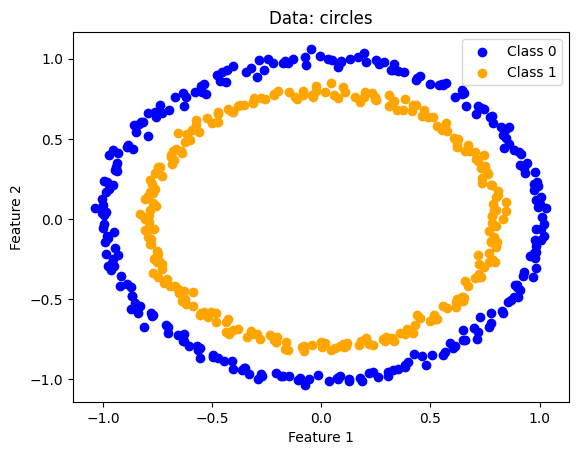

In [2]:
# -------------------------------------------------
# 1. Pilih Dataset
# -------------------------------------------------
torch.manual_seed(42)
np.random.seed(42)

dataset_choice = "circles"  

num_data = 500
if dataset_choice == "circles":
    X, y = make_circles(n_samples=num_data, noise=0.02, random_state=42)
elif dataset_choice == "classification":
    X, y = make_classification(
        n_samples=num_data,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_classes=2,
        random_state=42
    )
else:
    raise ValueError("Pilihan dataset tidak valid!")

plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="orange", label="Class 1")
plt.title(f"Data: {dataset_choice}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


---

Proses pembagian dataset menjadi data latih (train) dan uji (test), lalu menyiapkannya agar bisa diproses oleh model. Jumlah data latih ditentukan dengan train_size = 400 dan sisanya otomatis menjadi data uji sebanyak test_size = 100. Data fitur (X) dan label (y) kemudian dikonversi menjadi tensor PyTorch, dengan unsqueeze(1) pada label agar bentuknya sesuai dengan model (menjadi kolom vektor). Selanjutnya, data latih digabungkan ke dalam TensorDataset dan dimasukkan ke DataLoader dengan batch_size = 50. Penggunaan shuffle=True membuat urutan data diacak setiap epoch agar model tidak belajar berdasarkan urutan data. Bagian ini intinya menyiapkan data sehingga bisa dipakai dalam proses training ANN dengan cara yang lebih efisien.

---

In [3]:
# -------------------------------------------------
# 2. Split data train/test & DataLoader
# -------------------------------------------------
train_size = 400
test_size = num_data - train_size
batch_size = 50

x_train_pt = torch.tensor(X[:train_size], dtype=torch.float32)
y_train_pt = torch.tensor(y[:train_size], dtype=torch.float32).unsqueeze(1)

x_test_pt = torch.tensor(X[train_size:], dtype=torch.float32)
y_test_pt = torch.tensor(y[train_size:], dtype=torch.float32).unsqueeze(1)

train_set = TensorDataset(x_train_pt, y_train_pt)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


---

Arsitektur Artificial Neural Network (ANN) dengan tiga hidden layer dan satu output layer. Setiap layer terhubung penuh (Linear), lalu diberi fungsi aktivasi berbeda: ReLU di layer pertama, Tanh di layer kedua, LeakyReLU di layer ketiga, dan Sigmoid di output. Kombinasi ini dipakai untuk mengeksplorasi bagaimana berbagai aktivasi memengaruhi pembelajaran pada kasus klasifikasi biner.

---

In [4]:
# -------------------------------------------------
# 3. Definisi model ANN (Eksplorasi)
# -------------------------------------------------
class SimpleANN(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(SimpleANN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size1)
        self.fc2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = torch.nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = torch.nn.Linear(hidden_size3, output_size)

        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.leakyrelu = torch.nn.LeakyReLU(0.1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.leakyrelu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


---

Secara singkat, fungsi train_model di bawah menjalankan proses training ANN : data masuk ke model → dihitung loss (error) → dilakukan backpropagation → bobot model diperbarui oleh optimizer. Proses ini diulang tiap batch selama beberapa epoch (50), lalu nilai loss rata-rata tiap epoch disimpan dan ditampilkan sebagai progres belajar model.

---

In [5]:
# -------------------------------------------------
# 4. Fungsi Training
# -------------------------------------------------
def train_model(model, dataloader, criterion, optimizer, epochs=50):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return loss_history


---
Bagian ini adalah tahap pelatihan model. Pertama, dibuat objek model_ann dari kelas SimpleANN dengan 2 input, 3 hidden layer (16, 12, 8 neuron), dan 1 output. Fungsi loss yang dipakai adalah BCELoss karena kasusnya klasifikasi biner. Optimizer yang digunakan adalah Adam dengan learning rate 0.01 untuk memperbarui bobot model. Proses training dijalankan lewat fungsi train_model selama 100 epoch, dan nilai loss tiap epoch disimpan di loss_history. Terakhir, loss divisualisasikan dengan plot agar terlihat bagaimana model belajar dan apakah error makin menurun seiring bertambahnya epoch.

---

Epoch 1/100, Loss: 0.6963
Epoch 2/100, Loss: 0.6871
Epoch 3/100, Loss: 0.6850
Epoch 4/100, Loss: 0.6750
Epoch 5/100, Loss: 0.6591
Epoch 6/100, Loss: 0.6251
Epoch 7/100, Loss: 0.5786
Epoch 8/100, Loss: 0.5017
Epoch 9/100, Loss: 0.3918
Epoch 10/100, Loss: 0.2820
Epoch 11/100, Loss: 0.1807
Epoch 12/100, Loss: 0.1057
Epoch 13/100, Loss: 0.0752
Epoch 14/100, Loss: 0.0424
Epoch 15/100, Loss: 0.0372
Epoch 16/100, Loss: 0.0234
Epoch 17/100, Loss: 0.0171
Epoch 18/100, Loss: 0.0134
Epoch 19/100, Loss: 0.0111
Epoch 20/100, Loss: 0.0080
Epoch 21/100, Loss: 0.0073
Epoch 22/100, Loss: 0.0067
Epoch 23/100, Loss: 0.0050
Epoch 24/100, Loss: 0.0048
Epoch 25/100, Loss: 0.0044
Epoch 26/100, Loss: 0.0039
Epoch 27/100, Loss: 0.0034
Epoch 28/100, Loss: 0.0032
Epoch 29/100, Loss: 0.0030
Epoch 30/100, Loss: 0.0027
Epoch 31/100, Loss: 0.0026
Epoch 32/100, Loss: 0.0024
Epoch 33/100, Loss: 0.0022
Epoch 34/100, Loss: 0.0021
Epoch 35/100, Loss: 0.0020
Epoch 36/100, Loss: 0.0019
Epoch 37/100, Loss: 0.0020
Epoch 38/1

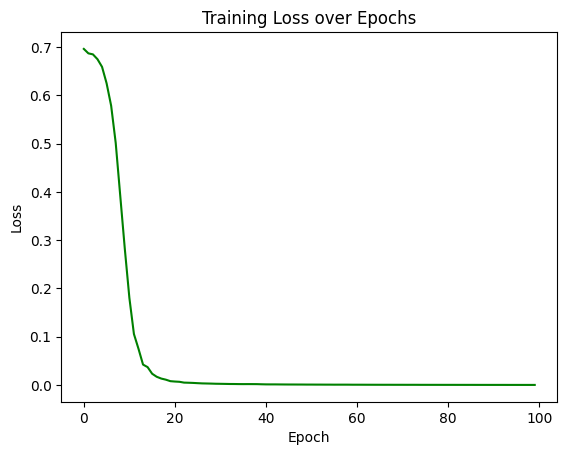

In [6]:
# -------------------------------------------------
# 5. Training Model
# -------------------------------------------------
model_ann = SimpleANN(input_size=2, hidden_size1=16, hidden_size2=12, hidden_size3=8, output_size=1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_ann.parameters(), lr=0.01)

loss_history = train_model(model_ann, train_loader, criterion, optimizer, epochs=100)

plt.plot(loss_history, color="green")
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [7]:
# -------------------------------------------------
# 6. Evaluasi Model
# -------------------------------------------------
model_ann.eval()
with torch.no_grad():
    y_pred = model_ann(x_test_pt)

metric = BinaryAccuracy(threshold=0.5)
accuracy = metric(y_pred, y_test_pt)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 1.0000



---

Output Test Accuracy: 1.0 artinya model mampu mengklasifikasikan seluruh data test set dengan benar tanpa ada kesalahan. Ini menunjukkan model sangat baik dalam mempelajari pola data pada dataset yang digunakan.
Beberapan alasan mengapa model bisa dikatakan sempurna kareena :
1. Dataset sederhana → Data make_circles atau make_classification dengan 2 fitur relatif mudah dipisahkan, sehingga ANN dengan arsitektur yang cukup kompleks bisa dengan cepat mencapai akurasi sempurna.
2. Overfitting mungkin terjadi → Walaupun test set kecil (100 data) juga ikut terklasifikasi sempurna, hasil ini tidak menjamin model akan bekerja sama baiknya pada data baru yang lebih bervariasi.
3. Arsitektur cukup kuat → Dengan 3 hidden layer (16–12–8 neuron) dan aktivasi beragam, model punya kapasitas tinggi untuk belajar bahkan pola non-linear yang sederhana sekalipun.
Singkatnya, akurasi 1.0 menunjukkan model terlalu cocok dengan dataset yang sederhana ini, sehingga perlu diuji dengan dataset lebih kompleks atau ditambahkan regularisasi agar terlihat performa realistisnya. 

---

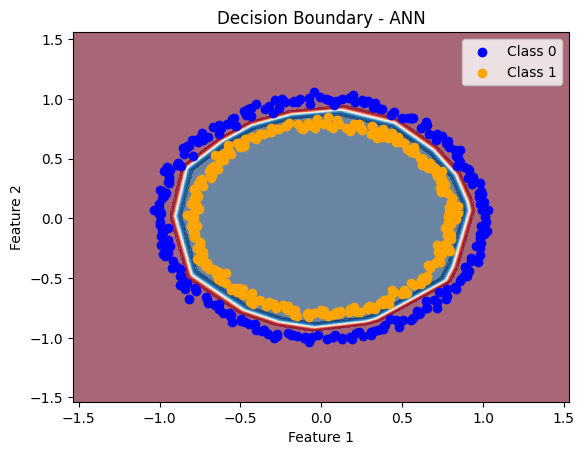

In [9]:
# -------------------------------------------------
# 7. Visualisasi Decision Boundary
# -------------------------------------------------
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
with torch.no_grad():
    Z = model_ann(grid_tensor)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z.numpy(), levels=50, cmap="RdBu", alpha=0.6)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="blue", label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", label="Class 1")
plt.title("Decision Boundary - ANN")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


Dari kesimpulan yang didapat, model ini terlalu sempurna. Sehingga agar tidak overfitting kita dapat mengubah beberapan komponen :
1. Arsitektur model → kurangi hidden layer/neuron, pakai aktivasi sederhana.

2. Regularisasi → tambahkan Dropout, gunakan weight decay (L2).

3. Data → bagi data agar lebih seimbang, tambahkan noise atau variasi data.

4. Training → kurangi epoch, atau pakai early stopping.

Di bawah ini adalah perubahan kode model agar tidak overfitting :



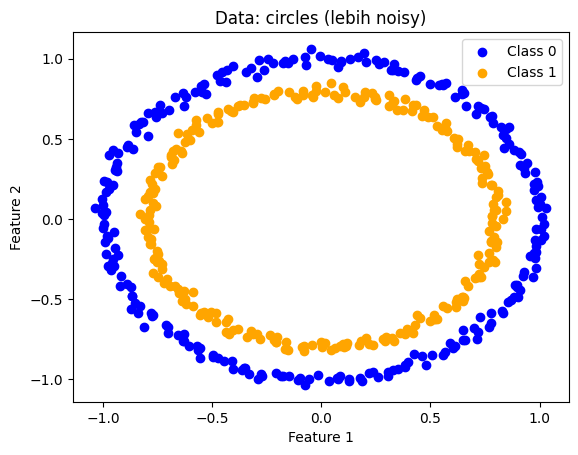

Epoch 1/50, Loss: 0.6974
Epoch 2/50, Loss: 0.6871
Epoch 3/50, Loss: 0.6797
Epoch 4/50, Loss: 0.6852
Epoch 5/50, Loss: 0.6859
Epoch 6/50, Loss: 0.6840
Epoch 7/50, Loss: 0.6815
Epoch 8/50, Loss: 0.6782
Epoch 9/50, Loss: 0.6743
Epoch 10/50, Loss: 0.6740
Epoch 11/50, Loss: 0.6737
Epoch 12/50, Loss: 0.6686
Epoch 13/50, Loss: 0.6621
Epoch 14/50, Loss: 0.6825
Epoch 15/50, Loss: 0.6602
Epoch 16/50, Loss: 0.6614
Epoch 17/50, Loss: 0.6469
Epoch 18/50, Loss: 0.6442
Epoch 19/50, Loss: 0.6479
Epoch 20/50, Loss: 0.6476
Epoch 21/50, Loss: 0.6368
Epoch 22/50, Loss: 0.6217
Epoch 23/50, Loss: 0.6169
Epoch 24/50, Loss: 0.6021
Epoch 25/50, Loss: 0.6175
Epoch 26/50, Loss: 0.6149
Epoch 27/50, Loss: 0.6159
Epoch 28/50, Loss: 0.5902
Epoch 29/50, Loss: 0.5682
Epoch 30/50, Loss: 0.5477
Epoch 31/50, Loss: 0.5506
Epoch 32/50, Loss: 0.5422
Epoch 33/50, Loss: 0.5492
Epoch 34/50, Loss: 0.5366
Epoch 35/50, Loss: 0.4884
Epoch 36/50, Loss: 0.5002
Epoch 37/50, Loss: 0.4996
Epoch 38/50, Loss: 0.4787
Epoch 39/50, Loss: 0.

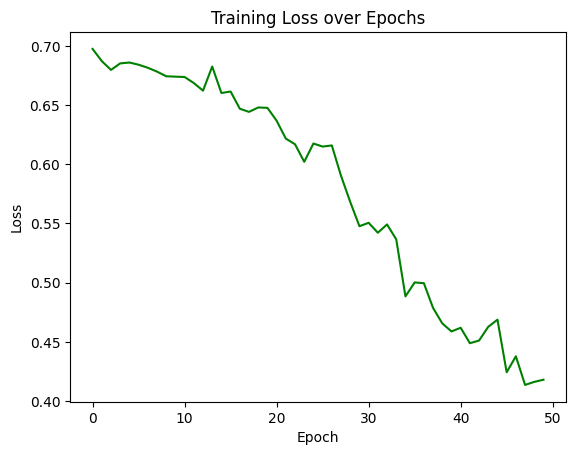

Test Accuracy: 0.9600


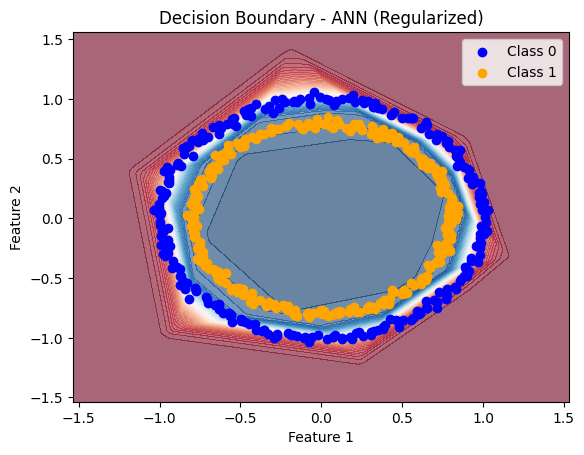

In [17]:
# -------------------------------------------------
# Modul 01 - Eksplorasi ANN untuk Klasifikasi Biner (dengan Regularisasi)
# -------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_circles, make_classification
from torchmetrics.classification import BinaryAccuracy

# -------------------------------------------------
# 1. Pilih Dataset (dengan noise tambahan)
# -------------------------------------------------
torch.manual_seed(42)
np.random.seed(42)

dataset_choice = "circles"  

num_data = 500
if dataset_choice == "circles":
    # noise ditingkatkan agar data lebih menantang
    X, y = make_circles(n_samples=num_data, noise=0.02, random_state=42)
elif dataset_choice == "classification":
    X, y = make_classification(
        n_samples=num_data,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_classes=2,
        flip_y=0.05,   # tambahkan label noise
        random_state=42
    )
else:
    raise ValueError("Pilihan dataset tidak valid!")

# Visualisasi data awal
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="orange", label="Class 1")
plt.title(f"Data: {dataset_choice} (lebih noisy)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# -------------------------------------------------
# 2. Split data train/test & DataLoader
# -------------------------------------------------
train_size = 400
test_size = num_data - train_size
batch_size = 50

x_train_pt = torch.tensor(X[:train_size], dtype=torch.float32)
y_train_pt = torch.tensor(y[:train_size], dtype=torch.float32).unsqueeze(1)

x_test_pt = torch.tensor(X[train_size:], dtype=torch.float32)
y_test_pt = torch.tensor(y[train_size:], dtype=torch.float32).unsqueeze(1)

train_set = TensorDataset(x_train_pt, y_train_pt)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# -------------------------------------------------
# 3. Definisi model ANN (lebih sederhana + dropout)
# -------------------------------------------------
class SimpleANN(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleANN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size1)
        self.fc2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = torch.nn.Linear(hidden_size2, output_size)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)   # dropout 30%
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

# -------------------------------------------------
# 4. Fungsi Training
# -------------------------------------------------
def train_model(model, dataloader, criterion, optimizer, epochs=50):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return loss_history

# -------------------------------------------------
# 5. Training Model (dengan weight decay)
# -------------------------------------------------
model_ann = SimpleANN(input_size=2, hidden_size1=8, hidden_size2=4, output_size=1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_ann.parameters(), lr=0.01, weight_decay=1e-4)

loss_history = train_model(model_ann, train_loader, criterion, optimizer, epochs=50)

plt.plot(loss_history, color="green")
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# -------------------------------------------------
# 6. Evaluasi Model
# -------------------------------------------------
model_ann.eval()
with torch.no_grad():
    y_pred = model_ann(x_test_pt)

metric = BinaryAccuracy(threshold=0.5)
accuracy = metric(y_pred, y_test_pt)
print(f"Test Accuracy: {accuracy:.4f}")

# -------------------------------------------------
# 7. Visualisasi Decision Boundary
# -------------------------------------------------
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
with torch.no_grad():
    Z = model_ann(grid_tensor)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z.numpy(), levels=50, cmap="RdBu", alpha=0.6)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="blue", label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", label="Class 1")
plt.title("Decision Boundary - ANN (Regularized)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


---

Dari hasil training tersebut terlihat bahwa loss turun secara konsisten dari sekitar 0.69 (awalnya mendekati tebakan acak untuk klasifikasi biner) hingga sangat kecil di akhir (~0.0003).
Model berhasil belajar dengan baik memisahkan dua kelas.
Penurunan loss cepat (mulai tajam di epoch 6–12) menunjukkan optimizer Adam + arsitektur ANN cukup efektif.
Loss yang sangat rendah mendekati nol mengindikasikan model mungkin hampir menghafal data train, yang bisa menyebabkan overfitting jika diuji pada data baru.

Walaupun training loss bagus, kita perlu lihat akurasi di test set atau lakukan regularisasi (dropout, early stopping, atau kurangi kompleksitas model) untuk memastikan model tidak terlalu overfit.

---



Dari model di atas dihasilkan arsitektur model lebih sederhana

1. Sebelumnya ada 3 hidden layer (16 → 12 → 8).
Sekarang dibuat lebih kecil: hanya 2 hidden layer (8 → 4).
Tujuannya: mengurangi kapasitas model supaya tidak terlalu kuat "menghafal".

2. Dropout ditambahkan
self.dropout = torch.nn.Dropout(0.3)
Dropout 30% setelah hidden layer (fc1 dan fc2).
Tujuannya: mematikan sebagian neuron secara acak saat training → mencegah neuron tertentu dominan → meningkatkan generalisasi.

3. Weight decay (L2 regularization) pada optimizer
optimizer = torch.optim.Adam(model_ann.parameters(), lr=0.01, weight_decay=1e-4)
Weight decay menambahkan penalti pada bobot yang terlalu besar.
Tujuannya: mencegah model overfitting dengan menjaga bobot tetap kecil.

4. Jumlah epoch dikurangi
Sebelumnya epochs=100, sekarang epochs=50.
Tujuannya: menghindari model terlalu lama belajar → bisa jadi malah overfit.

Dari model ini didapat Test Accuracy: 0.9600, yang mencegah overfitting